In [1]:
from datetime import datetime
from functools import partial
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import numpy as np
import joblib

from wandb_utils import get_wandb_history
from plotting import plot_metric, plot_multi_validator_metric
from utils import average_challenges_per_tempo
from simulator import run_simulation

[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with custom encoding error
handler: 'OutStream' object has no attribute 'reconfigure'


## Query W&B or Load Locally Cached Data

In [3]:
# `load_cached_history` = True will read local pickle file at fname
# `load_cached_history` = False will query W&B
load_cached_history = True 
write_to_history_cache = True
fname = 'vali_histories_2days.pkl'

#  Earlist time (epoch) from which to pull W&B runs
start_ts = 1727803270 #1727846400 # 1727886242 #

# Names of W&B runs to query
validator_uids = [131, 193, 107]#, 19, 107] # [6, 17, 19, 20, 107, , 236, 250, 20, 122
VALIDATORS = ['validator-193-1.1.0', 'validator-19-1.1.0', 'validator-107-1.1.0']
VALIDATORS = [f'validator-{uid}-1.1.0' for uid in validator_uids]

# Keys will be validator names, values will be history dataframes
HISTORY_DFS = {}


In [4]:
if load_cached_history:
    HISTORY_DFS = joblib.load(fname)
else:
    for vali in VALIDATORS:
        print(f"Loading data from {vali}")
        HISTORY_DFS[vali] = get_wandb_history(
            project='bitmind-subnet',
            entity='bitmindai',
            validator_name=vali,
            start_ts=start_ts,
            end_ts=None, 
            verbosity=0)

    if write_to_history_cache:
        joblib.dump(HISTORY_DFS, fname)

for vali, history_df in HISTORY_DFS.items():
    print(vali)
    avg, counts = average_challenges_per_tempo(history_df)
    format_time = lambda v: datetime.fromtimestamp(v).strftime('%Y-%m-%dT%H:%M:%S')
    print(f'\tDate Range: {format_time(history_df._timestamp.min())} : {format_time(history_df._timestamp.max())}')
    print(f'\tDataFrame shape: {history_df.shape}')
    print(f'\tAverage Challenges Per Tempo: {avg}')
    print(f'\t\tChallenges Per Tempo: {counts}')
    

validator-131-1.1.0
	Date Range: 2024-10-01T15:28:19 : 2024-10-03T17:22:32
	DataFrame shape: (2106, 4)
	Average Challenges Per Tempo: 50.142857142857146
		Challenges Per Tempo: [56, 59, 56, 59, 54, 55, 58, 58, 59, 59, 56, 60, 58, 58, 59, 58, 58, 58, 57, 57, 54, 54, 57, 59, 56, 58, 58, 59, 58, 57, 3, 0, 0, 0, 0, 55, 60, 57, 59, 59, 57, 34]
validator-193-1.1.0
	Date Range: 2024-10-01T14:36:14 : 2024-10-03T17:24:31
	DataFrame shape: (2487, 4)
	Average Challenges Per Tempo: 57.83720930232558
		Challenges Per Tempo: [60, 57, 58, 60, 56, 59, 57, 58, 58, 58, 60, 60, 60, 59, 60, 58, 60, 58, 59, 58, 57, 54, 55, 58, 59, 58, 61, 59, 60, 61, 58, 60, 59, 60, 60, 57, 60, 59, 60, 60, 59, 60, 20]
validator-107-1.1.0
	Date Range: 2024-10-01T13:33:38 : 2024-10-03T17:24:54
	DataFrame shape: (2288, 4)
	Average Challenges Per Tempo: 52.0
		Challenges Per Tempo: [51, 52, 53, 53, 50, 54, 57, 53, 53, 54, 54, 55, 52, 54, 53, 52, 54, 55, 54, 50, 50, 54, 47, 50, 57, 52, 53, 52, 53, 53, 54, 51, 55, 53, 55, 52, 51

In [7]:
HISTORY_DFS = {vali: HISTORY_DFS[vali] for vali in VALIDATORS}

In [7]:
HISTORY_DFS['validator-131-1.1.0']

,_timestamp,miner_uid,pred,label
0,1.727796e+09,"[100, 66, 85, 197, 217, 10, 243, 41, 162, 81, ...","[0.35462761678156063, 0.28378872060722454, 0.0...",0
1,1.727797e+09,"[8, 206, 65, 60, 24, 232, 234, 29, 143, 0, 113...","[1, 0.6586156023301245, 0.3508857488632202, 0....",1
2,1.727797e+09,"[35, 202, 229, 242, 138, 239, 176, 234, 12, 24...","[-1, -1, 0.79, 0.5036028622927186, 0.893869259...",1
3,1.727797e+09,"[136, 241, 208, 202, 95, 27, 75, 4, 28, 172, 2...","[-1, 0.10077116735786823, 0, -1, 0, 0.15243972...",0
4,1.727797e+09,"[51, 86, 80, 163, 237, 36, 44, 10, 172, 33, 29...","[0.99, 0.8823463076492837, 0.99, 0.87647923656...",1
...,...,...,...,...
83,1.727976e+09,"[195, 111, 121, 207, 16, 154, 157, 118, 33, 76...","[0.344542335481554, 1, 0.4386799728604106, 0.0...",1
84,1.727976e+09,"[143, 78, 119, 60, 21, 34, 169, 11, 49, 214, 5...","[0.20111518858298533, 0.047977702341011785, 0....",0
85,1.727976e+09,"[128, 12, 233, 58, 87, 196, 53, 133, 241, 85, ...","[0.3490070791051317, 0.46077277026444025, 0.39...",0
86,1.727976e+09,"[205, 154, 227, 164, 237, 255, 145, 96, 132, 5...","[0, 0.07173212060708084, 0, 0, 0.3480513498659...",0


## Run Simulation or Load Simulation Results

In [5]:
# `load_cached_scores` = False will run simulations for each validator with the specified reward functions in parallel
# `load_cached_scores` = True will read local pickle file
load_cached_scores = False  

# `write_to_cache` = True will overwrite scored_fname
write_to_cache = True
scored_fname = 'histories_scored_glicko_test.pkl'

# Number of dataframe rows over which to compute rewards and scores, set to `None` for all rows
score_num_challenges = None

# Keys are validator (w&b run) names, values are dataframes with reward & score columns
SCORED_DFS = {}

In [9]:
if load_cached_scores:
    SCORED_DFS = joblib.load(scored_fname)
else:  
    simulation_fn = partial(run_simulation, limit=score_num_challenges)

    # progress bar is kinda jank with multiprocessing, could fix but nah
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(
            simulation_fn,
            [HISTORY_DFS[vali] for vali in VALIDATORS])
    
    SCORED_DFS = {vali: scored_df[scored_df.rewards_new.notna()] for vali, scored_df in zip(VALIDATORS, results)}
    if write_to_cache:
        joblib.dump(SCORED_DFS, scored_fname)

Computing Rewards, Scores and Weights: 100%|██████████| 2487/2487 [09:49<00:00,  4.22it/s]


In [8]:
from weights import U16_MAX

for vali, scored_df in SCORED_DFS.items():
    SCORED_DFS[vali]['weights_normed_old'] = scored_df['weights_old'].apply(lambda l: [v/U16_MAX for v in l])
    SCORED_DFS[vali]['weights_normed_new'] = scored_df['weights_new'].apply(lambda l: [v/U16_MAX for v in l])

#SCORED_DFS[vali]

In [12]:
WEIGHT_SET_DFS = {vali: df.iloc[::360] for vali, df in SCORED_DFS.items()}


In [ ]:
WEIGHT_SET_DFS[

## Plot Rewards and Scores 
**Note: Variable y-axis ranges**

**"New" refers to weights/scores/rewards from the new reward functions, "old" is the original binary reward function**

Todo: update x axis to be human readable timestamp 

## reward100 * .5 + reward10 * .25 + correct * .25

In [13]:
uids = [5, 226, 179, 172]#, 39]
start_idx = 0
end_idx = -1

### Inspect Same Miner over Multiple Validators

#### Weights
note that weights aren't actually set this often (this shows per challenge)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 plot_multi_validator_metric(                                                                │
│    2 │   WEIGHT_SET_DFS,                                                                         │
│    3 │   idx_range=[start_idx, end_idx],                                                         │
│    4 │   metric='weights_normed',                                                                │
│                                                                                                  │
│ /home/user/scoring_simulator/plotting.py:106 in plot_multi_validator_metric                      │
│                                                                                                  │
│   103 │   plt.ylabel(metric.capitalize())                                                        │
│   104 │   plt.title(f"Miner {metric.capitalize()} Over Time")                                    │
│   105 │   handles, labels = plt.gca().get_legend_handles_labels()                                │
│ ❱ 106 │   labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))               │
│   107 │   plt.legend(handles, labels, loc=legend_loc)                                            │
│   108 │   plt.show();                                                                            │
│   109                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: not enough values to unpack (expected 2, got 0)

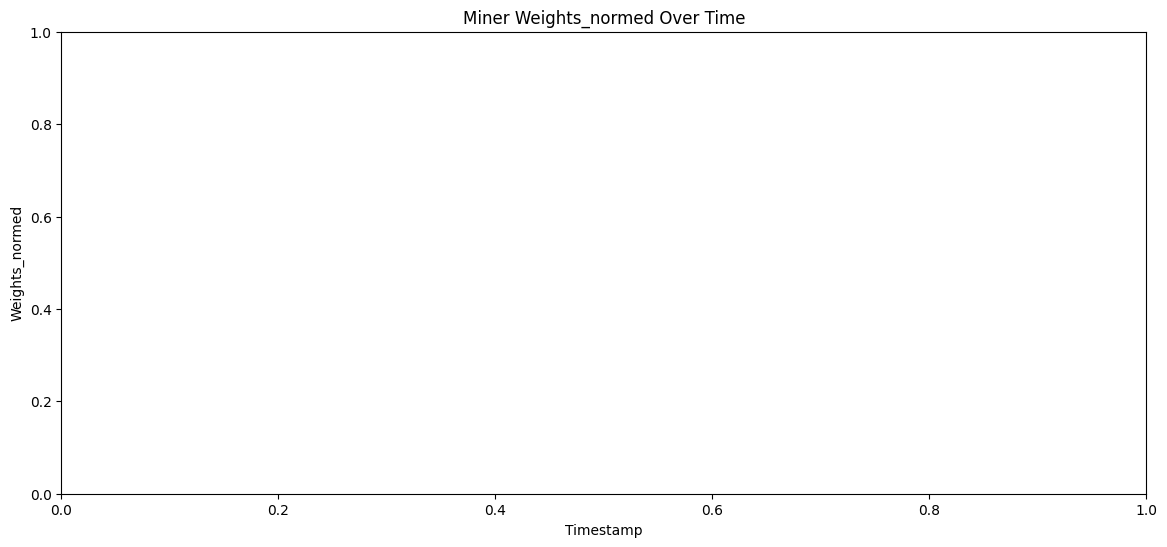

In [14]:


plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='weights_normed', 
    suffixes=['new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')
plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='weights_normed', 
    suffixes=['old'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')

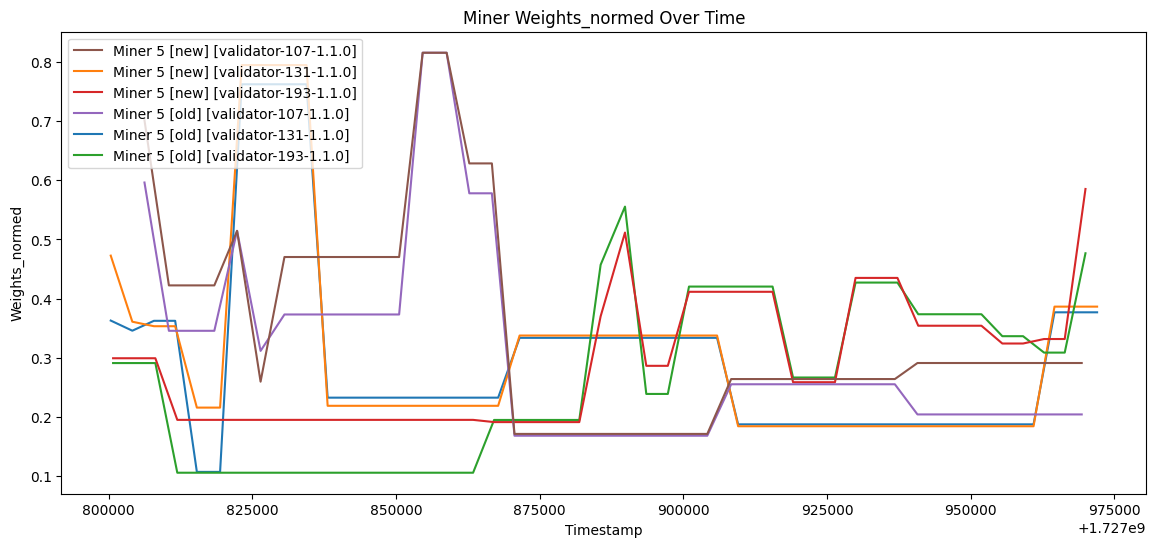

In [15]:


plot_multi_validator_metric(
    WEIGHT_SET_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='weights_normed', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='upper left')


#### Scores

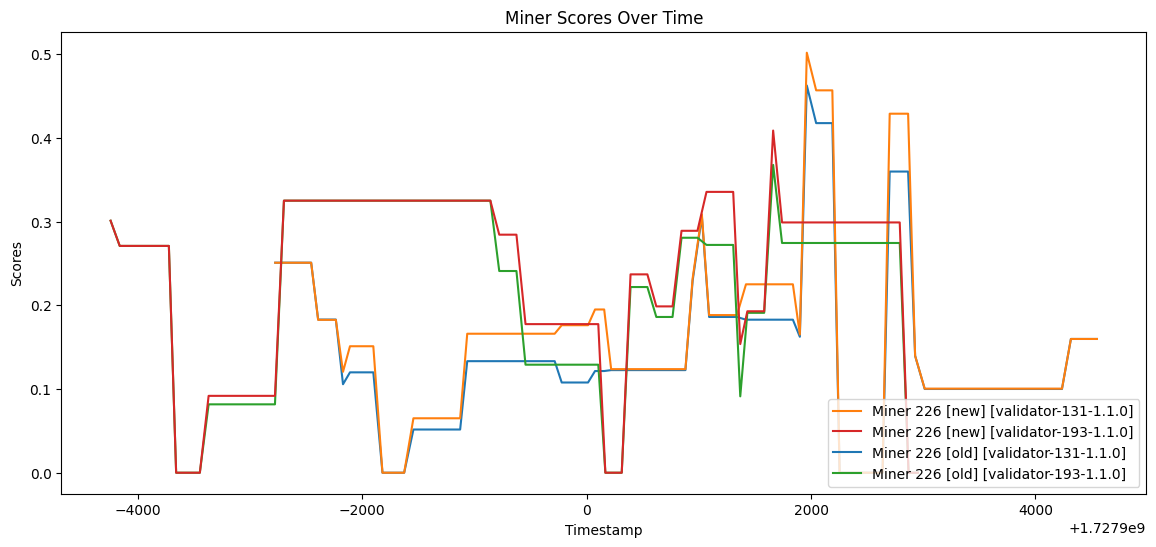

In [11]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='scores', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower right')

#### Rewards

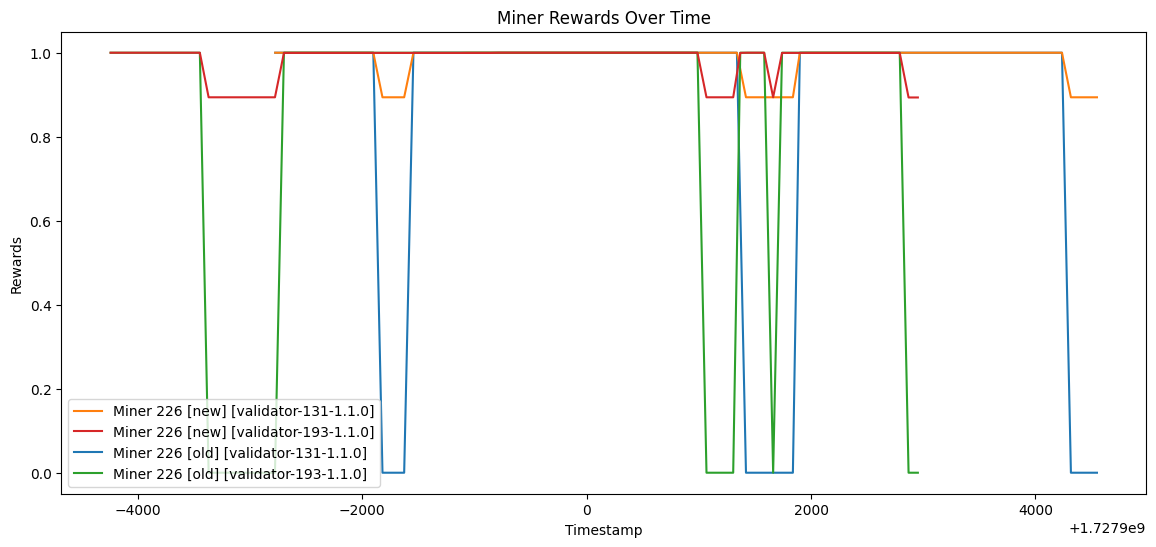

In [12]:
plot_multi_validator_metric(
    SCORED_DFS, 
    idx_range=[start_idx, end_idx], 
    metric='rewards', 
    suffixes=['old', 'new'], 
    uids=[uids[0]], 
    map_uids_to_colors=False,
    legend_loc='lower left')

### Inspect Individual Validators

validator-131-1.1.0


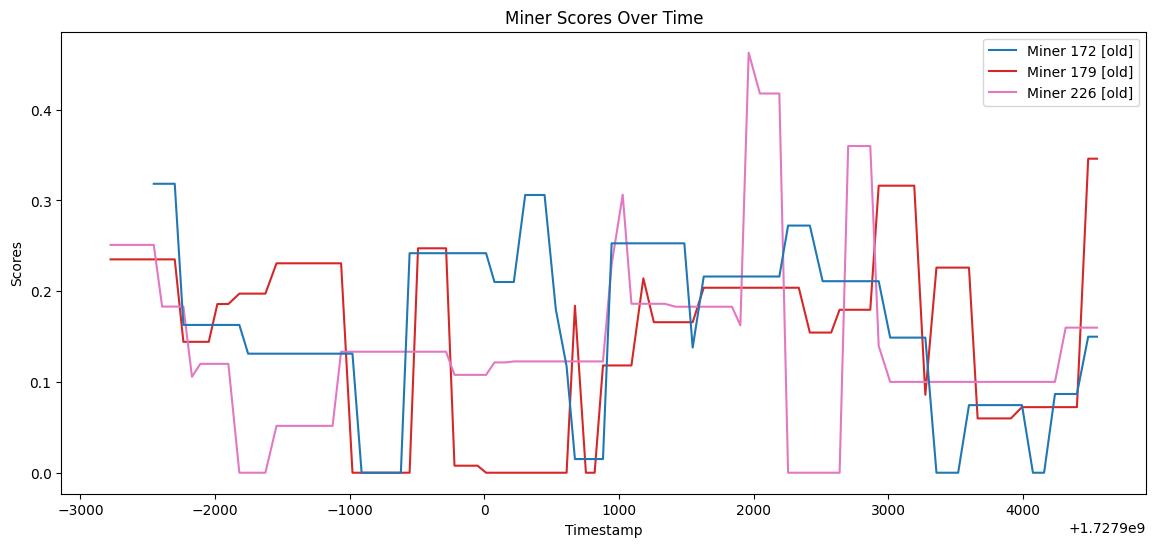

validator-193-1.1.0


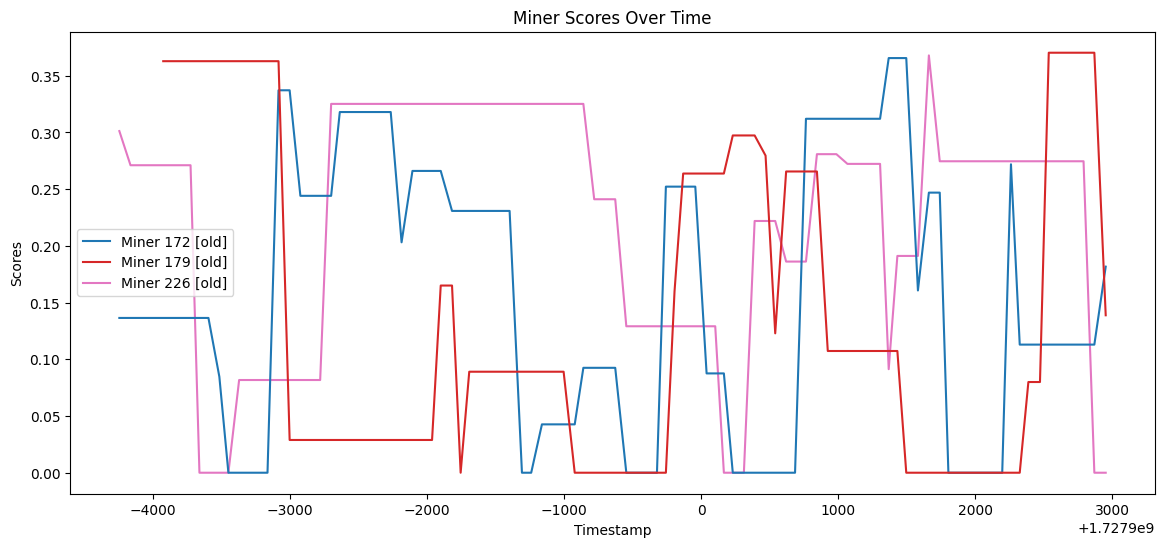

In [14]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=uids, suffixes=['old'], map_uids_to_colors=True)


validator-131-1.1.0


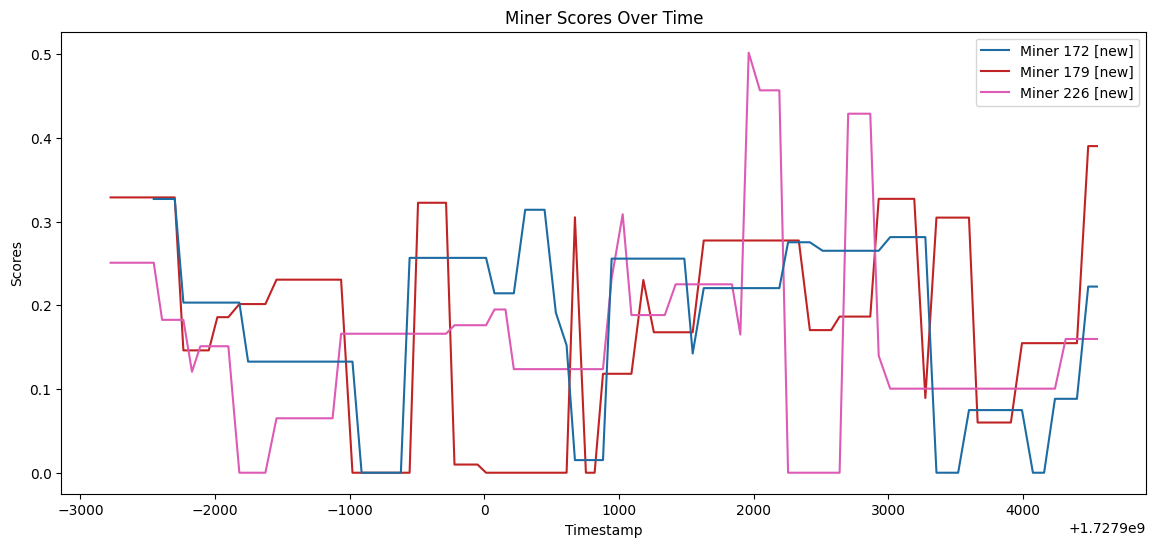

validator-193-1.1.0


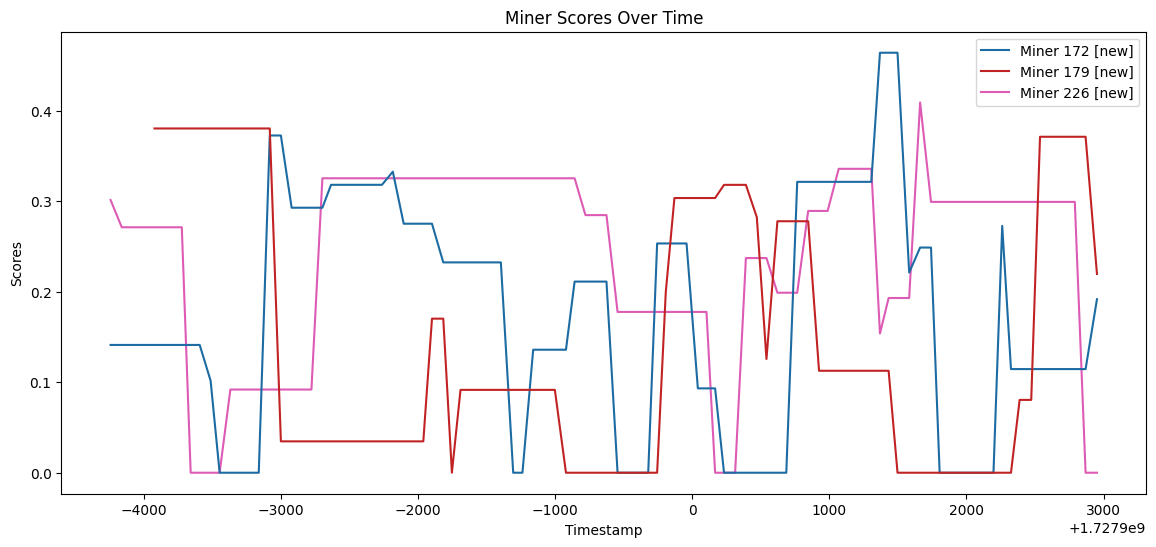

In [15]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=uids, suffixes=['new'], map_uids_to_colors=True)


validator-131-1.1.0


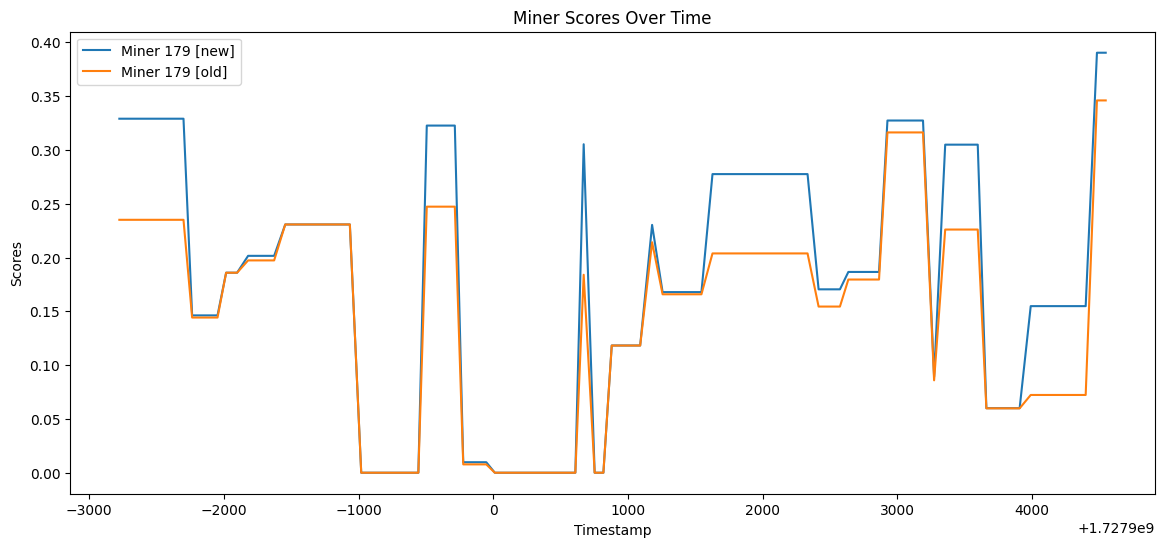

validator-193-1.1.0


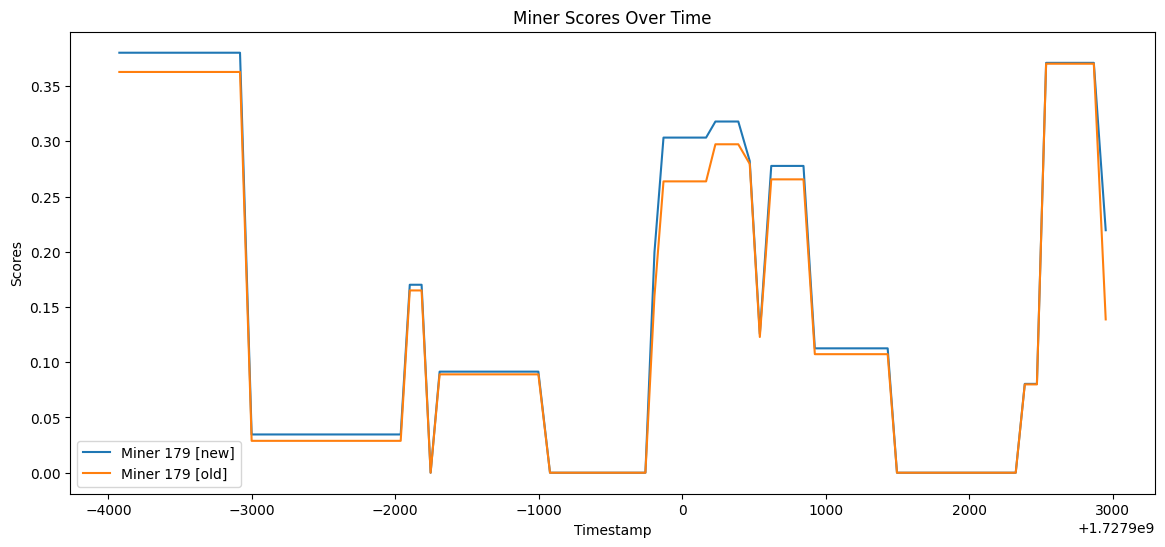

In [17]:

for vali, scored_df in SCORED_DFS.items():
    print(vali)
    plot_metric(scored_df[start_idx: end_idx], 'scores', uids=[uids[1]], suffixes=['new', 'old'], map_uids_to_colors=False)


## ---------- Older Results (pre-multivalidator plotting) ----------

## reward100 * .5 + reward10 * .25 + correct * .25

In [13]:
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=map_uids_to_colors)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plot_metric(scored_df, 'scores', uids=uids, suffixes=['new', 'old'], map_uids_to_colors=     │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'map_uids_to_colors' is not defined

In [ ]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['new'], map_uids_to_colors=map_uids_to_colors)


In [ ]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, suffixes=['old'], map_uids_to_colors=map_uids_to_colors)


## reward10 * .2 + correct * .8

In [ ]:
uids = [5,25,95,100]
map_uids_to_colors = True

plot_metric(scored_df, 'rewards', uids=uids, map_uids_to_colors=map_uids_to_colors)
plot_metric(scored_df, 'scores', uids=uids, map_uids_to_colors=map_uids_to_colors)
